In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score

To be able to process locally, we will use 1% of data. After that, we still have a large number of 241,179 records.

In [3]:
df = pd.read_csv('train.csv.gz', sep=',').dropna()
df = df.sample(frac=0.01, random_state=99)

In [4]:
df.shape

(241179, 24)

In [5]:
df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
32352134,2014-05-22 11:40:07,2,3,66,174,24103,2323.5232,802499,0,1,...,0,1,1442,3,0,1,4,125,177,44
29796021,2013-06-29 12:24:37,2,3,66,311,25538,2288.6121,85229,0,0,...,1,1,8272,1,0,1,2,50,659,59
15185156,2014-10-30 13:58:32,2,3,66,294,40046,587.6970,755217,0,1,...,0,1,11321,1,0,1,2,50,642,22
3301948,2014-08-22 20:14:34,2,3,66,332,55121,2234.4394,160733,0,1,...,0,1,1152,1,1,1,4,47,1502,65
25429119,2014-03-25 18:47:43,2,3,66,314,47869,839.0087,1078493,0,0,...,0,1,8284,1,0,4,2,50,685,6


Text(0,0.5,'Frequency')

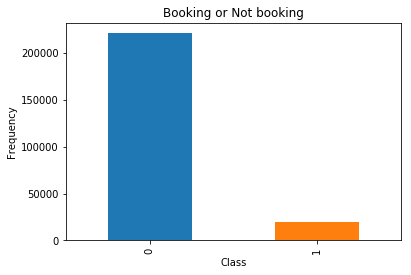

In [6]:
count_classes = pd.value_counts(df['is_booking'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Booking or Not booking")
plt.xlabel("Class")
plt.ylabel("Frequency")

It is obvious that our data is very imbalanced. We will have to deal with it.

Data quality check

In [7]:
df.isnull().sum()

date_time                    0
site_name                    0
posa_continent               0
user_location_country        0
user_location_region         0
user_location_city           0
orig_destination_distance    0
user_id                      0
is_mobile                    0
is_package                   0
channel                      0
srch_ci                      0
srch_co                      0
srch_adults_cnt              0
srch_children_cnt            0
srch_rm_cnt                  0
srch_destination_id          0
srch_destination_type_id     0
is_booking                   0
cnt                          0
hotel_continent              0
hotel_country                0
hotel_market                 0
hotel_cluster                0
dtype: int64

In [8]:
df.dtypes

date_time                     object
site_name                      int64
posa_continent                 int64
user_location_country          int64
user_location_region           int64
user_location_city             int64
orig_destination_distance    float64
user_id                        int64
is_mobile                      int64
is_package                     int64
channel                        int64
srch_ci                       object
srch_co                       object
srch_adults_cnt                int64
srch_children_cnt              int64
srch_rm_cnt                    int64
srch_destination_id            int64
srch_destination_type_id       int64
is_booking                     int64
cnt                            int64
hotel_continent                int64
hotel_country                  int64
hotel_market                   int64
hotel_cluster                  int64
dtype: object

### Feature engineering
The process includes create new columns such as year, month, plan time and hotel nights. And remove the columns we do not need anymore afterwards.

In [9]:
df["date_time"] = pd.to_datetime(df["date_time"]) 
df["year"] = df["date_time"].dt.year  
df["month"] = df["date_time"].dt.month

df['srch_ci']=pd.to_datetime(df['srch_ci'],infer_datetime_format = True,errors='coerce')
df['srch_co']=pd.to_datetime(df['srch_co'],infer_datetime_format = True,errors='coerce')

df['plan_time'] = ((df['srch_ci']-df['date_time'])/np.timedelta64(1,'D')).astype(float)
df['hotel_nights']=((df['srch_co']-df['srch_ci'])/np.timedelta64(1,'D')).astype(float)

cols_to_drop = ['date_time', 'srch_ci', 'srch_co', 'user_id']
df.drop(cols_to_drop, axis=1, inplace=True)

In [10]:
df.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,...,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,plan_time,hotel_nights
32352134,2,3,66,174,24103,2323.5232,0,1,9,2,...,0,1,4,125,177,44,2014,5,62.513808,0.0
29796021,2,3,66,311,25538,2288.6121,0,0,9,3,...,0,1,2,50,659,59,2013,6,5.482905,4.0
15185156,2,3,66,294,40046,587.6970,0,1,9,2,...,0,1,2,50,642,22,2014,10,49.417685,3.0
3301948,2,3,66,332,55121,2234.4394,0,1,9,2,...,1,1,4,47,1502,65,2014,8,153.156551,7.0
25429119,2,3,66,314,47869,839.0087,0,0,9,4,...,0,4,2,50,685,6,2014,3,22.216863,3.0


Plot a correlation matrix using a heatmap to explore the correlation between features. Nothing really exciting here. 

Text(0.5,1,'Correlation between different fearures')

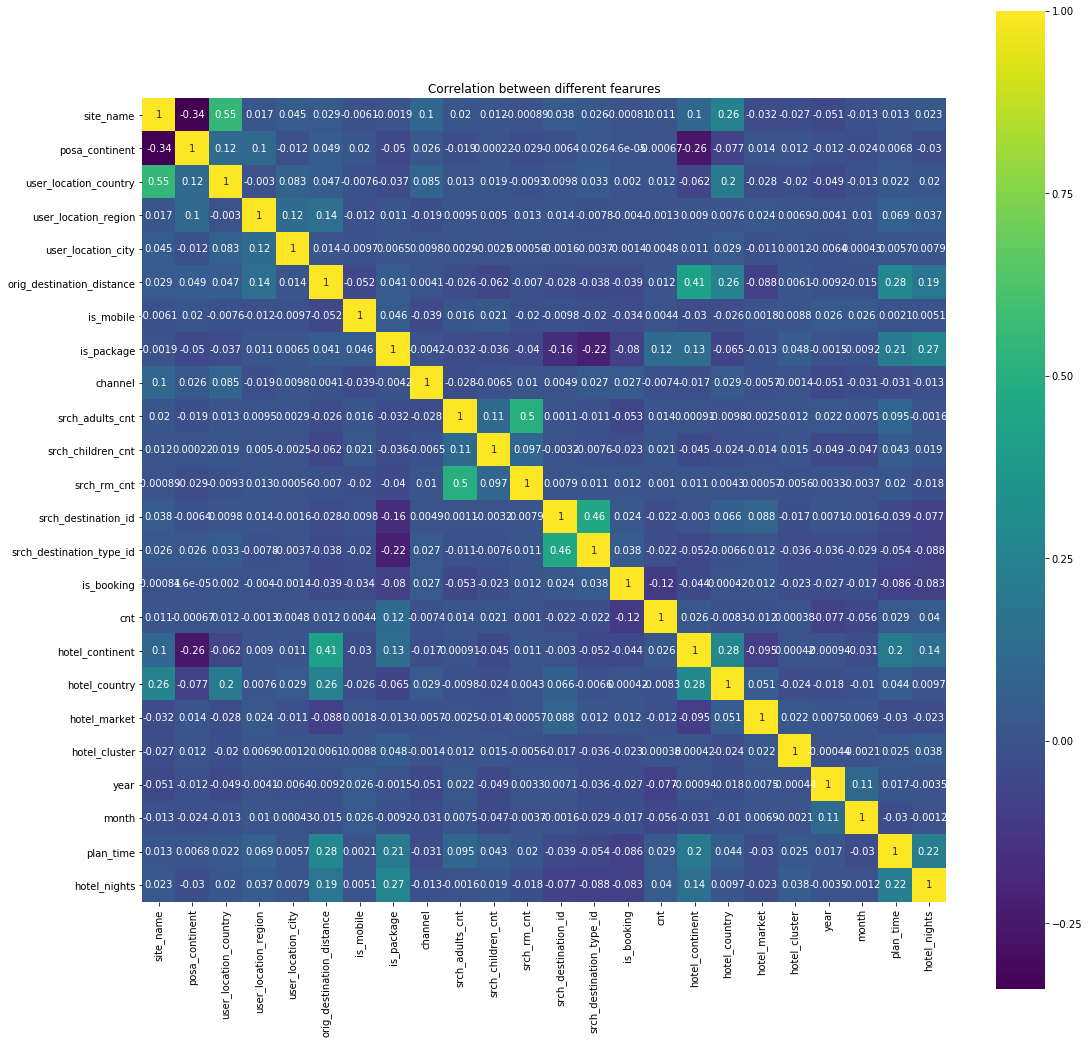

In [11]:
correlation = df.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')

plt.title('Correlation between different fearures')

Look at the correlation of each column compared to the other one. We do not see any two variables are very closely correlated.

### Dealing with imbalanced data

In [12]:
booking_indices = df[df.is_booking == 1].index
random_indices = np.random.choice(booking_indices, len(df.loc[df.is_booking == 1]), replace=False)
booking_sample = df.loc[random_indices]

not_booking = df[df.is_booking == 0].index
random_indices = np.random.choice(not_booking, sum(df['is_booking']), replace=False)
not_booking_sample = df.loc[random_indices]

df_new = pd.concat([not_booking_sample, booking_sample], axis=0)

print("Percentage of not booking clicks: ", len(df_new[df_new.is_booking == 0])/len(df_new))
print("Percentage of booking clicks: ", len(df_new[df_new.is_booking == 1])/len(df_new))
print("Total number of records in resampled data: ", len(df_new))

Percentage of not booking clicks:  0.5
Percentage of booking clicks:  0.5
Total number of records in resampled data:  40064


Shuffle the resampled dataframe.

In [13]:
df_new = df_new.sample(frac=1).reset_index(drop=True)

In [14]:
df_new.shape

(40064, 24)

Assign features and label from the new dataframe.

In [15]:
X = df_new.loc[:, df_new.columns != 'is_booking']
y = df_new.loc[:, df_new.columns == 'is_booking']

In [16]:
X.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,...,srch_destination_type_id,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,plan_time,hotel_nights
0,2,3,66,322,56444,3961.4587,0,0,9,5,...,5,1,2,50,636,28,2014,12,208.604306,2.0
1,34,3,205,155,19334,948.0112,0,1,9,2,...,1,2,2,50,628,45,2014,10,33.616632,3.0
2,2,3,66,346,21180,5121.8768,0,0,0,2,...,1,1,6,70,135,16,2014,1,39.366493,2.0
3,2,3,66,174,24103,334.1044,0,0,9,6,...,1,1,2,50,1230,33,2013,8,9.344062,2.0
4,2,3,66,174,5746,115.7918,0,0,9,2,...,1,1,2,50,627,32,2013,10,7.106215,2.0


## PCA 
Principal component analysis, or PCA, is a statistical technique to convert high dimensional data to low dimensional data by selecting the most important features that capture maximum information about the dataset.

Standardize the dataset

In [17]:
scaler = StandardScaler()
X=scaler.fit_transform(X)
X

array([[-0.46199337,  0.17933751, -0.40303549, ...,  1.51901039,
         2.82235649, -0.28179178],
       [ 3.06852659,  0.17933751,  2.15367292, ...,  0.90975169,
        -0.16984298,  0.05510374],
       [-0.46199337,  0.17933751, -0.40303549, ..., -1.83191241,
        -0.0715233 , -0.28179178],
       ...,
       [-0.46199337,  0.17933751, -0.40303549, ...,  0.300493  ,
        -0.54599567,  0.05510374],
       [-0.46199337,  0.17933751, -0.40303549, ...,  0.90975169,
         0.29921357, -0.28179178],
       [-0.46199337,  0.17933751, -0.40303549, ...,  1.21438104,
        -0.20302251, -0.61868729]])

Apply PCA. And we have 23 features in our data.

In [18]:
pca = PCA(n_components=23)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=23, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Calculate Eigenvalues

In [19]:
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var

array([  9.2,  17.3,  24.1,  30.4,  36. ,  41.2,  46.1,  50.7,  55.2,
        59.6,  63.9,  68. ,  72.1,  76. ,  79.9,  83.6,  86.9,  89.9,
        92.4,  94.7,  96.8,  98.8, 100.1])

In the above array we see that the first feature explains 9.3% of the variance within our data set while the first two explain 17.3% and so on. If we employ all features we capture 99.9% of the variance within the dataset, thus we gain some by implementing an additional feature. No any single feature outstanding.

Step 4: Sort & Select

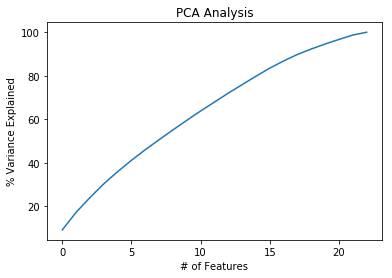

In [20]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')

plt.plot(var)

Based on the plot above it's clear we should keep all 23 features.

### Train, predict and performance evaluation

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train.shape

(28044, 23)

In [22]:
pca = PCA()  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)

classifier = RandomForestClassifier(max_depth=2, random_state=0)  
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy', accuracy_score(y_test, y_pred))

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


[[3486 2531]
 [1873 4130]]
Accuracy 0.6336106489184692


### Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
pca = PCA(n_components=23)
logReg = LogisticRegression() 

pipe = Pipeline([('pca', pca), ('logistic', logReg)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy', accuracy_score(y_test, y_pred))

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[3226 2791]
 [1008 4995]]
Accuracy 0.6839434276206323
